# Import ModSim library 

We would be using the modsim library available as https://github.com/AllenDowney/ModSimPy/blob/master/modsim/modsim.pyhttps://github.com/AllenDowney/ModSimPy/blob/master/modsim/modsim.py

In [19]:
from modsim import *
import numpy as np

# Extended Minimal Model

The Bergman minimal model was extended to incorporate (Free fatty acids) FFA dynamics and its interaction with glucose and insulin. Modifications were made to the original model structure by adding extra compartments as shown in figure below. Compartment *F(t)* represents the plasma FFA concentration. Similar to compartment *X(t)* in the Bergman minimal model, an unaccessible compartment *Y(t)* was added to the FFA model representing the remote insulin concentration inhibiting FFA release from the Adipose tissue (AT) into the circulatory system. An additional first order filter, compartment *Z(t)*, was added to the model to represent the remote FFA concentration affecting glucose uptake dynamics.
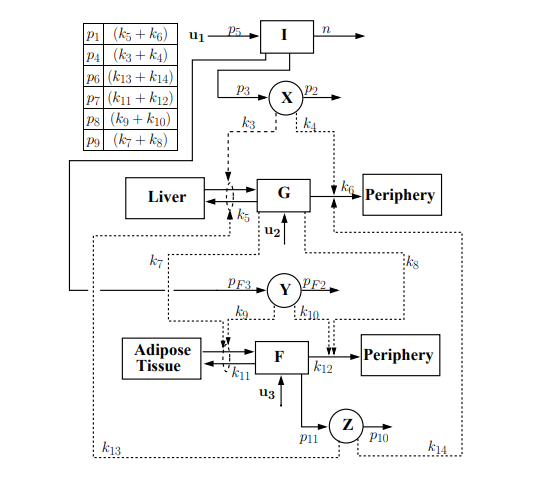. 

# Implementing the Model

To get started, let's assume that the parameters of the model are known.
We'll implement the model and use it to generate time series for `G` , `X`, `I`, `Y`, `Z` and `F`. 
Then we'll see how we can choose parameters that make the simulation fit the data.

Here are the parameters.

In [37]:
p1 = 0.068       # 1/min
p2 = 0.037       # 1/min
p3 = 0.000012    # 1/min
p4 = 1.3         # mL/(min * micro-U)
p5 = 0.000568    # 1/mL
p6 = 0.00006     # 1/(min * micro-mol)
p7 = 0.03        # 1/min
p8 = 4.5         # mL/(min * micro-U)

In [38]:
k1 = 0.02        # 1/min
k2 = 0.03        # 1/min
pF2 = 0.17       # 1/min
pF3 = 0.00001    # 1/min
n = 0.142        # 1/min
VolG = 117       # dL
VolF = 11.7      # L

I'll put these values in a sequence which we'll pass to `make_system`:

In [39]:
params = p1, p2, p3, p4, p5, p6, p7, p8, k1, k2, pF2, pF3, n, VolG, VolF

Here's a version of `make_system` that takes `params` as parameters.

In [46]:
def make_system(params):
    p1, p2, p3, p4, p5, p6, p7, p8, k1, k2, pF2, pF3, n, VolG, VolF = params
    
    t_0 = 0
    t_end = 200
    
    #Basal parameters
    Ib = 0           # Insulin (micro-U/mL)
    Xb = 0           # Remote insulin (micro-U/mL)
    Gb = 98          # Blood Glucose (mg/dL)
    Yb = 0           # Insulin for Lipogenesis (micro-U/mL)
    Fb = 380         # Plasma Free Fatty Acid (micro-mol/L)
    Zb = 380         # Remote Free Fatty Acid (micro-mol/L)

    ## I = interpolate(data.insulin)
    # insulin infusion rate
    u1 = 3           # micro-U/min

    # glucose uptake rate
    u2 = 300         # mg/min

    # external lipid infusion
    u3 = 0           # mg/min    
    
    init = State(I=27.4, X=0, G=98, Y=0, F=38, Z=38, u1=3, u2=300, u3=0)
    
    return System(init=init, params=params,
                  Xb=Xb, Ib=Ib, Gb=Gb, Yb = Yb, Fb=Fb, Zb=Zb,
                  t_0=t_0, t_end=t_end, dt=10)

In [47]:
system = make_system(params)

# The Update Function

In [54]:
def update_func(t, state, system):
    G, X, I, Y, F, Z, u1, u2, u3 = state
    p1, p2, p3, p4, p5, p6, p7, p8, k1, k2, pF2, pF3, n, VolG, VolF = system.params
    Ib, Gb, Xb, Yb, Fb, Zb = system.Ib, system.Gb, system.Xb, system.Yb, system.Fb, system.Zb
    dt = system.dt

    # Insulin dynamics
    dIdt = -n*I  + p5*u1

    # Remote insulin compartment dynamics
    dXdt = -p2*X + p3*I

    # Glucose dynamics
    dGdt = -p1*G - p4*X*G + p6*G*Z + p1*Gb - p6*Gb*Zb + u2/VolG

    # Insulin dynamics for lipogenesis
    dYdt = -pF2*Y + pF3*I

    # Intermediates
    p9 = 0.00021 * np.exp(-0.0055*G)  # dL/(min*mg)
    # End Intermediates

    # Plasma Free Fatty Acid (FFA) dynamics
    dFdt = -p7*(F-Fb) - p8*Y*F + p9 * (F*G-Fb*Gb) + u3/VolF
    
    # Remote FFA dynamics
    dZdt = -k2*(Z-Zb) + k1*(F-Fb)
    # End Equations
    
    I += dIdt * dt
    X += dXdt * dt
    G += dGdt * dt
    Y += dYdt * dt
    F += dFdt * dt
    Z += dZdt * dt

    return State(I=I, X=X, G=G, Y=Y, F=F,Z=Z, u1=u1, u2=u2, u3=u3)

In [55]:
update_func(system.t_0, system.init, system)

I     -41.142960
X       0.011760
G      79.329746
Y       0.009800
F      75.216933
Z      72.200000
u1      3.000000
u2    300.000000
u3      0.000000
Name: state, dtype: float64

## Running the Simulation

We'll use the following version of `run_simulation`:

In [56]:
def run_simulation(system, update_func):    
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    frame = TimeFrame(index=t_array, 
                      columns=system.init.index)
    frame.iloc[0] = system.init
    
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)
    
    return frame

When we make the TimeFrame, we use index to indicate that the index is the array of time stamps, t_array, and columns to indicate that the column names are the state variables we get from init.

We can run it like this:

In [57]:
results = run_simulation(system, update_func)

The result is a `TimeFrame` with a row for each time step and a column for each of the state variables, `G` and `X`.
Here are the first few time steps.

In [58]:
results.head()

,I,X,G,Y,F,Z,u1,u2,u3
0.0,27.400000,0.000000,98.000000,0.000000,38.000000,38.000000,3.0,300.0,0.0
10.0,-41.142960,0.011760,79.329746,0.009800,75.216933,72.200000,3.0,300.0,0.0
20.0,-33.301453,0.016928,61.278901,0.001073,27.269466,103.583387,3.0,300.0,0.0
30.0,-25.720098,0.018018,64.539485,0.005377,35.558264,115.962264,3.0,300.0,0.0
40.0,-27.089544,0.019096,65.941693,0.002690,37.987322,126.285237,3.0,300.0,0.0


The following plot shows the simulated glucose levels from the model along with the measured data. 

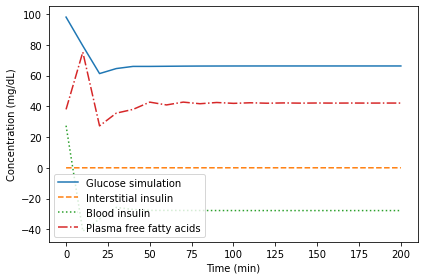

In [76]:
results.G.plot(style='-', label='Glucose simulation')
results.X.plot(style='--', label = 'Interstitial insulin')
results.I.plot(style=':', label = 'Blood insulin')
results.F.plot(style='-.', label = 'Plasma free fatty acids')


decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')
